# Analysis

In [1]:
import os, glob
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read input data

In [2]:
def script_read_multiruns():
    IN_PARENT_DIR = '/Users/anthony/Playground/tensorboard_logs/sr_return/2021-01-21/07-14-12'
    Prog_File_wc = '*/progress.csv'
    Config_File_wc = '*/.hydra/config.yaml'
    
    PD_DF_SEP = '\|'
    
    
    def get_progress_file_dict_key(path_str):
        """Helper method to get dict key for both the progress files
        and the config files"""
        return path_str.split('/')[-2]
    
    def get_config_file_dict_key(path_str):
        return path_str.split('/')[-3]
        
    mr_dict = {}
    
    prog_file_path_list = glob.glob(os.path.join(IN_PARENT_DIR, Prog_File_wc))
    for path in prog_file_path_list:
        d_k = get_progress_file_dict_key(path)
        mr_dict[d_k] = {
            'df': pd.read_csv(path, sep=PD_DF_SEP)
        }
    
    for path in glob.glob(os.path.join(IN_PARENT_DIR, Config_File_wc)):
        d_k = get_config_file_dict_key(path)
        mr_dict[d_k]['config'] = yaml.load(open(path))
    
    return mr_dict
        
        

DataDict = script_read_multiruns()
len(DataDict)

/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


4

#### Get all attributes into columns and concate all runs

In [3]:
import collections

def construct_data_df(runs_dict):    
    def recursive_helper(configDict, curStr='', headerDict={}):
        """Helper to extract all the nested attributes into a
        single attribute dict"""
        # Base case: no child dictionaries
        if not isinstance(configDict, collections.Mapping):
            headerDict[curStr] = str(configDict)
            return None
        
        # Recursion
        for k in configDict:
            if len(curStr) == 0:
                childStr = k
            else:
                childStr = f'{curStr}.{k}'
            recursive_helper(configDict[k], childStr, headerDict)
        return None
    
    # ==
    # Add configs to dataframes and concat
    all_df_list = []
    
    for run_k in runs_dict:
        cur_run_dict = runs_dict[run_k]
        
        # Extract header
        config_dict = {}
        recursive_helper(cur_run_dict['config'], 
                         curStr='', 
                         headerDict=config_dict)
        
        
        # Add to dataframe
        cur_df = cur_run_dict['df'].copy(deep=True)
        for header_k in config_dict:
            col_val = config_dict[header_k]
            cur_df[header_k] = [col_val] * len(cur_df)
            
        
        all_df_list.append(cur_df)
        
    # ==
    # Concat and output
    all_concat_df = pd.concat(all_df_list)
    all_concat_df = all_concat_df.reset_index()
    
    return all_concat_df


Data_df = construct_data_df(DataDict)
print(len(Data_df))
Data_df[0:3]

1820


/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  


,index,"2021-01-21 07:14:22,231",Unnamed: 1,episode_count,total_steps,episode_return,exp_average_return,value_loss,reward_loss,sf_loss,...,algo.kwargs.trace_lambda,algo.kwargs.entropy_beta,algo.kwargs.grad_rms_gamma,algo.kwargs.grad_rms_eps,algo.kwargs.min_denom,model.cls_string,model.kwargs.fc_sizes,"2021-01-21 08:26:46,020","2021-01-21 10:58:00,678","2021-01-21 09:42:00,742"
0,0,"2021-01-21 07:14:27,242",NaN,100,1066,0.46,0.2747868150737452,0.04362880483900699,None,None,...,0.0,0.01,0.999,0.0001,0.0001,ACNetwork,128,NaN,NaN,NaN
1,1,"2021-01-21 07:14:32,227",NaN,200,2148,0.47,0.3779216160590847,0.03936976974864948,None,None,...,0.0,0.01,0.999,0.0001,0.0001,ACNetwork,128,NaN,NaN,NaN
2,2,"2021-01-21 07:14:37,045",NaN,300,3172,0.42,0.4045995241326716,0.033605155723305746,None,None,...,0.0,0.01,0.999,0.0001,0.0001,ACNetwork,128,NaN,NaN,NaN


In [4]:
print(Data_df.columns.values.tolist())

['index', '2021-01-21 07:14:22,231', 'Unnamed: 1', 'episode_count', 'total_steps', 'episode_return', 'exp_average_return', 'value_loss', 'reward_loss', 'sf_loss', 'et_loss', 'training.seed', 'runner.n_steps', 'runner.kwargs.log_interval_episodes', 'runner.kwargs.log_dir_path', 'env.kwargs.env_name', 'algo.cls_string', 'algo.kwargs.discount_gamma', 'algo.kwargs.lr_alpha', 'algo.kwargs.trace_lambda', 'algo.kwargs.entropy_beta', 'algo.kwargs.grad_rms_gamma', 'algo.kwargs.grad_rms_eps', 'algo.kwargs.min_denom', 'model.cls_string', 'model.kwargs.fc_sizes', '2021-01-21 08:26:46,020', '2021-01-21 10:58:00,678', '2021-01-21 09:42:00,742']


## Explatory Plots

In [5]:
set(Data_df['algo.cls_string'].values)

{'ACLambda'}

In [6]:
set(Data_df['algo.kwargs.trace_lambda'].values)

{'0.0', '0.8'}

In [7]:
set(Data_df['model.kwargs.fc_sizes'].values)

{'128'}

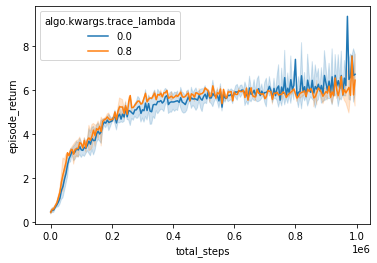

In [11]:
def round_2_int(value, nearest=10):
    try:
        rounded = int(value / nearest) * nearest
    except ValueError:
        rounded = np.nan
    return rounded

def simple_lineplot(x, y, hue, data, 
                    ci='sd', n_boot=20, 
                    round_x=None, round_y=None,
                    filters=None):    
    df = data.copy(deep=True)
    # In case non numeric
    df[x] = pd.to_numeric(df[x], errors='coerce')
    df[y] = pd.to_numeric(df[y], errors='coerce')
    # if roudning
    if round_x is not None:
        df[x] = [round_2_int(v, round_x) for v in df[x].values]
    if round_y is not None:
        df[y] = [round_2_int(v, round_y) for v in df[y].values]

    
    if filters is not None:
        for f_k in filters:
            df = df[df[f_k] == filters[f_k]]
    
    sns.lineplot(x=x, y=y, hue=hue, 
                 ci=ci,
                 n_boot=n_boot,
                 data=df)
    
simple_lineplot(
        x='total_steps', y='episode_return', 
        hue='algo.kwargs.trace_lambda', 
        round_x=5e3,
        data=Data_df,
)

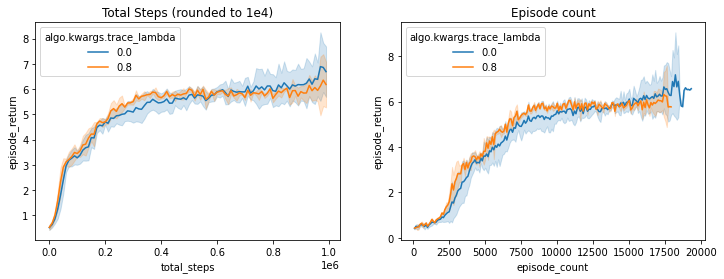

In [9]:
def script_episode_steps_return():
    plt_hue = 'algo.kwargs.trace_lambda'
    plt_y = 'episode_return'
    plt_ci = 'sd'
    plt_n_boot = 200
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    simple_lineplot(
        x='total_steps', y=plt_y, 
        hue='algo.kwargs.trace_lambda', 
        round_x=1e4,
        ci=plt_ci, n_boot=plt_n_boot,
        data=Data_df,
    )
    plt.title('Total Steps (rounded to 1e4)')
    
    plt.subplot(1,2,2)
    simple_lineplot(
        x='episode_count', y=plt_y, 
        hue='algo.kwargs.trace_lambda', 
        ci=plt_ci, n_boot=plt_n_boot,
        data=Data_df,
    )
    plt.title('Episode count')
    
    
script_episode_steps_return()

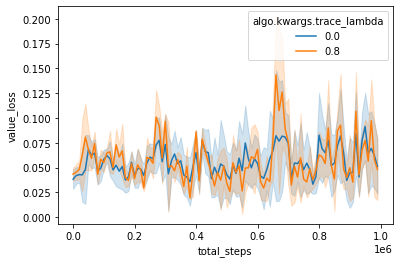

In [10]:
simple_lineplot(
        x='total_steps', y='value_loss', 
        hue='algo.kwargs.trace_lambda', 
        round_x=1e4,
        data=Data_df,
)

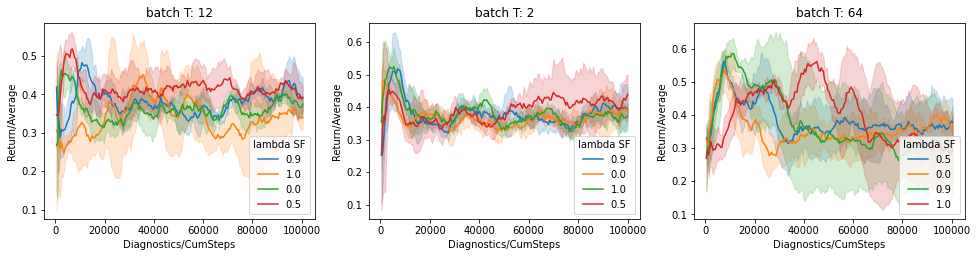

In [23]:
def tmp_subplots():
    tmp_attris = sorted(list(set(Data_df['sampler.kwargs.batch_T'].values)))
    
    plt.figure(figsize=(16.5,3.6))
    for i, att in enumerate(tmp_attris):
        plt.subplot(1,len(tmp_attris), i+1)
        

        simple_lineplot(
            x='Diagnostics/CumSteps', y='Return/Average', 
            hue='algo.kwargs.sf_lambda', 
            data=Data_df,
            filters={
                'sampler.kwargs.batch_T': att,
                'model.kwargs.detach_sf_grad': 'True', 
                'model.kwargs.sf_hidden_sizes': '[512]'}
        )
        plt.title(f'batch T: {att}')
        plt.legend(loc='lower right', title='lambda SF')
tmp_subplots()